In [2]:
import os
import sys
import glob
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')

pplt.rc.update({
    'reso':'xx-hi',
    'font.size':11,
    'figure.dpi':100,
    'figure.facecolor':'black',
    'savefig.facecolor':'black',
    'axes.facecolor':'white',
    'axes.edgecolor':'white',
    'axes.labelcolor':'white',
    'tick.color':'white',
    'tick.labelcolor':'white',
    'title.color':'white',
    'colorbar.edgecolor':'white'})

In [4]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   

In [5]:
weightfiles = list(glob.glob(f'{WEIGHTSDIR}/*_weights.nc'))
if not weightfiles:
    print('No weight files found')
else:
    print(f'Found {len(weightfiles)} weight files!')

Found 1 weight files!


In [6]:
ds = xr.open_dataset(weightfiles[0])

In [8]:
weights = ds.weights
levs = ds.lev.values

def spacing(coord):
    coord = np.asarray(coord, dtype=np.float64)
    delta = np.empty_like(coord)
    delta[1:-1]   = 0.5*(coord[2:] - coord[:-2])
    delta[[0,-1]] = (coord[1] - coord[0], coord[-1] - coord[-2])
    return np.abs(delta)

dp_hpa = spacing(levs) * 100.0                      
mass   = weights * xr.DataArray(dp_hpa, dims=('lev',), coords={'lev': levs})

P = mass.sizes['lev']

means = mass.mean(dim='member')
# stds  = mass.std(dim='member')

mins = mass.min(dim='member')
maxs = mass.max(dim='member')

In [9]:
# index of max weight along lev
imax = mass.argmax(dim='lev')

# convert index → pressure
p_dom = ds.lev.isel(lev=imax)

# ensemble mean + spread
p_dom_mean = p_dom.mean(dim='member')
p_dom_std  = p_dom.std(dim='member')


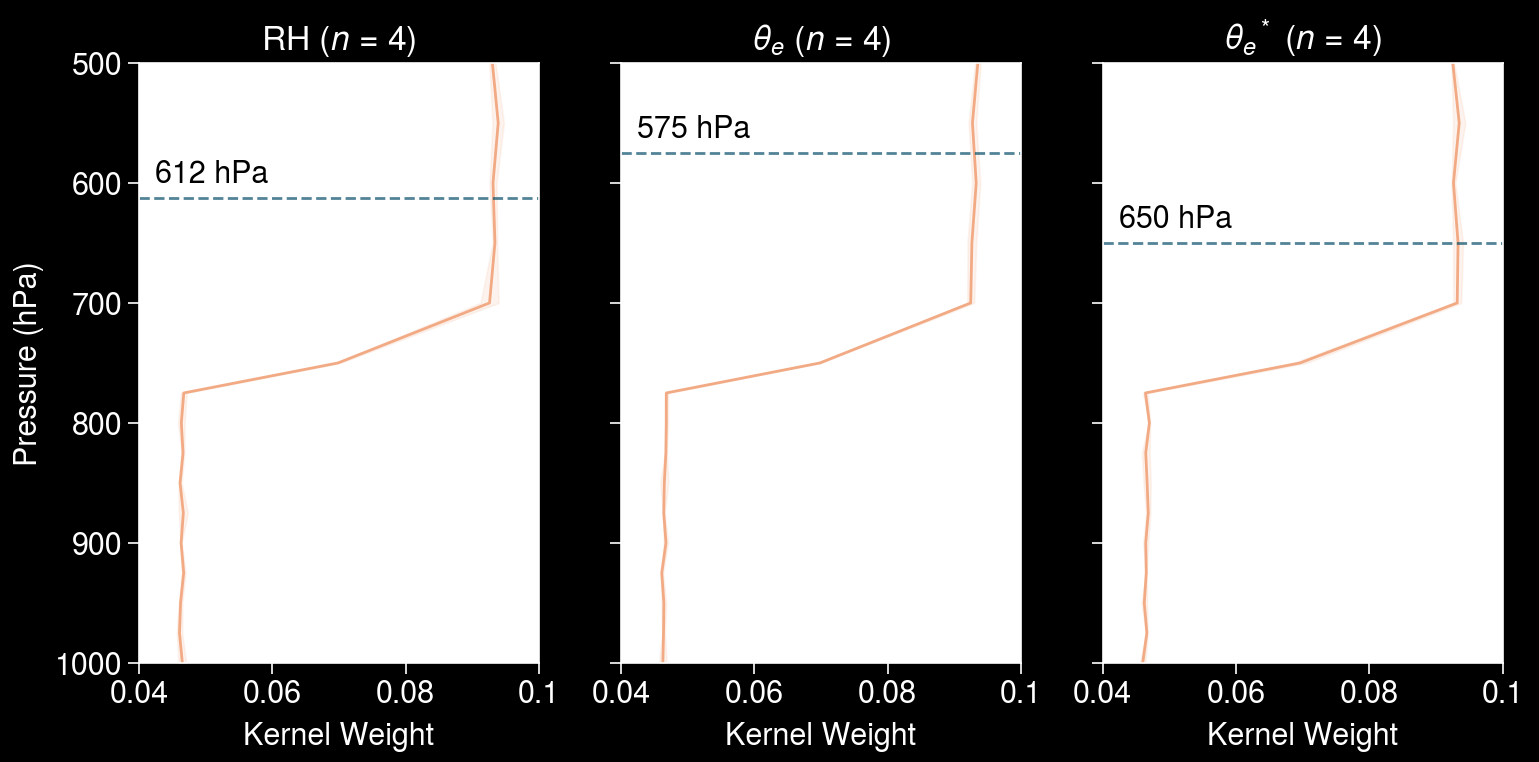

In [10]:
labels  = [r'RH ($\mathit{n}$ = 4)',r'$\mathit{\theta_e}$ ($\mathit{n}$ = 4)',r'$\mathit{\theta_e}^*$ ($\mathit{n}$ = 4)']     

fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,refheight=3,sharey=True,sharex=False)
axs.format(xlabel='Kernel Weight',xlim=(0.04,0.1),xminorticks='none',xreverse=False,grid=False,
           ylabel='Pressure (hPa)',yminorticks='none',yreverse=True)
for i,ax in enumerate(axs):
    mean = means[i,:]
    std  = stds[i,:]
    axs.format(xreverse=False)
    ax.plot(mean,levs,color='#f2aa84',linewidth=1,label='Mean')
    ax.fill_betweenx(levs,mean-std,mean+std,color='#f6c7ad',alpha=0.2,label=r'± 1$\sigma$')


    p_imp = p_dom_mean.isel(field=i).item()

    ax.axhline(p_imp, ls='--', lw=1, color='#084f6a',alpha=0.7)

    ax.text(
        0.04, p_imp-7,f"{p_imp:.0f} hPa",
        transform=ax.get_yaxis_transform(),  # x in axes coords, y in data coords
        ha='left', va='bottom')


    ax.format(title=labels[i])
# axs[0].legend(loc='ul',ncols=1)
pplt.show()
fig.save('../figs/agu_weights.jpg',bbox_inches='tight')